In [433]:
# -*- coding: utf-8 -*-

import pandas as pd, numpy as np
import seaborn as sns                   # Graphing
sns.set(style="white")  
# Read recipe inputs
df = pd.read_csv("actual.csv")



In [434]:
list(df)

['Country',
 'Year',
 'Language',
 'Country Code',
 'Debt',
 'Account Balance',
 'Corruption',
 'GeoPoint',
 'Foreign_Investment',
 'GDP',
 'Inflation',
 'Ethnicity',
 'Religion',
 'unemployment',
 'Natural Ressources',
 'Infant Mortality',
 'incompatibility',
 'intensity_level',
 'minor conflict',
 'war',
 'conflict',
 'internationalized internal',
 'internal',
 'interstate',
 'extrasymetric',
 'emergence',
 'War emergence']

# periodogramme

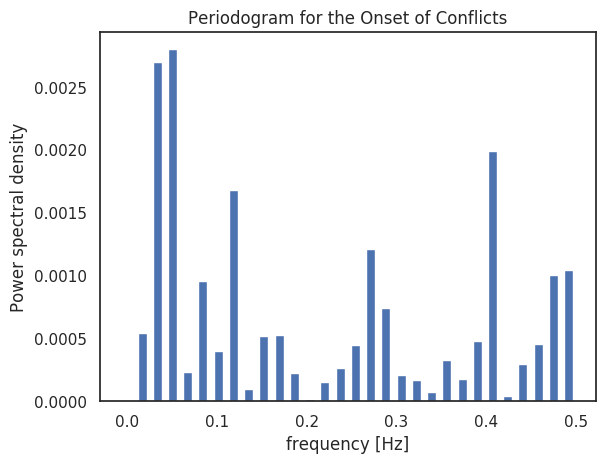

[(0.05084745762711865, 19.666666666666664), (0.03389830508474576, 29.5), (0.4067796610169492, 2.458333333333333), (0.11864406779661017, 8.428571428571429)]


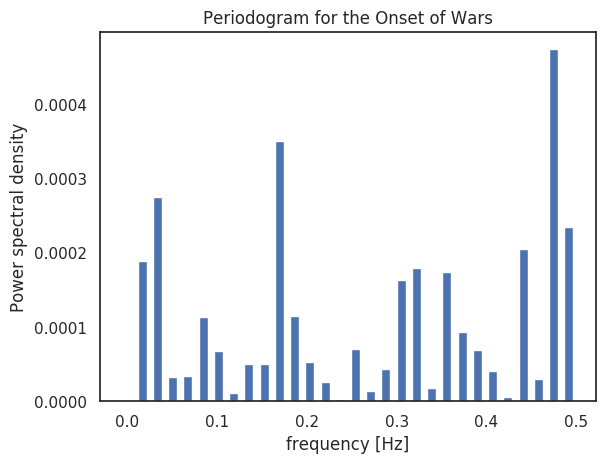

[(0.4745762711864407, 2.107142857142857), (0.1694915254237288, 5.9), (0.03389830508474576, 29.5), (0.4915254237288136, 2.0344827586206895)]


In [437]:
import scipy.signal as signal
conflicts = df.groupby(['Year'])["emergence"].mean()
f, Pxx_spec = signal.periodogram(conflicts, 1.0)
plt.bar(f[0:], Pxx_spec[0:], width=0.01)
plt.xlabel('frequency [Hz]')
plt.ylabel('Power spectral density')
plt.title('Periodogram for the Onset of Conflicts')
plt.show()

maxs = Pxx_spec.argsort()[-4:][::-1]
print([( f[i], 1/f[i]) for i in maxs] )

conflicts = df.groupby(['Year'])["War emergence"].mean()
f, Pxx_spec = signal.periodogram(conflicts, 1.0)
plt.bar(f[0:], Pxx_spec[0:], width=0.01)
plt.xlabel('frequency [Hz]')
plt.ylabel('Power spectral density')
plt.title('Periodogram for the Onset of Wars')
plt.show()

maxs = Pxx_spec.argsort()[-4:][::-1]
print([( f[i], 1/f[i]) for i in maxs] )


# Autocorrelation

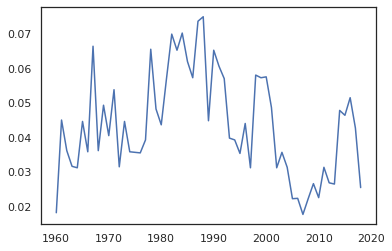

In [3]:
import matplotlib.pyplot as plt
wars = df.groupby("Year")["war"].mean()
plt.plot(wars)
plt.show()

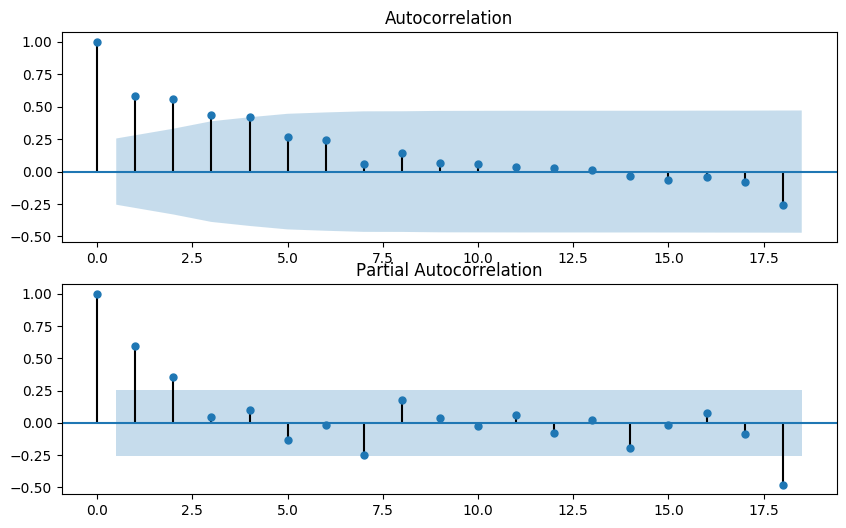

In [80]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, figsize = (10,6))
ax[0] = plot_acf(wars, ax = ax[0])
ax[1] = plot_pacf(wars, ax = ax[1])
plt.savefig("Auto_correlation_wars.png")
plt.show()

# Granger causality

In [41]:
from statsmodels.tsa.stattools import grangercausalitytests
X_train = df.groupby("Year")[['Debt',
 'Account Balance',
 'Foreign_Investment',
 'GDP',
 'Inflation',
 'unemployment',
 'Natural Ressources',
 'Infant Mortality',
 'minor conflict',
 'war',
 'conflict',
 'internationalized internal',
 'internal',
 'interstate',
 'emergence']].mean().copy()
X_train.dropna(inplace = True)
maxlag = 5
test= "ssr_chi2test"
def granger_causation_matrix(data, variables, test = "ssr_chi2test", verbose = False):
    X_train = pd.DataFrame(np.zeros((len(variables), len(variables))), columns = variables, index = variables)
    for c in X_train.columns:
        for r in X_train.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag = maxlag,verbose = False )
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag) ]
            if verbose: print(f'Y={r}, X={c}, P values={p_values}')
            min_p_values = np.min(p_values)
            X_train.loc[r,c] = min_p_values
    X_train.columns = [var + "_x" for var in variables]
    X_train.index = [var + "_y" for var in variables]
    return X_train

corr = granger_causation_matrix(X_train, variables = X_train.columns)

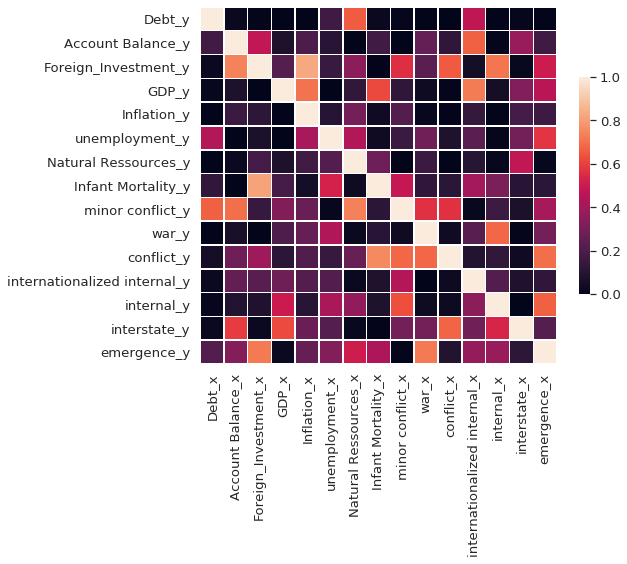

In [53]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#0et up the matplotlib figure
size = max(8, len(corr.columns)/2.)
f, ax = plt.subplots(figsize=(size, size))
sns.set(font_scale=1.2)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, square=True, linewidths=.5, cbar_kws={"shrink": 0.5}, ax=ax)
plt.savefig("Granger_causality.png")

# natural ressources

In [127]:
dix = df[df["Natural Ressources"] <= 10].groupby("Year")["war"].mean()
#deux = df[(df["Natural Ressources"] > 10) & (df["Natural Ressources"] <= 25) ].groupby("Year")["war"].mean()
Trois = df[df["Natural Ressources"] >10].groupby("Year")["war"].mean()

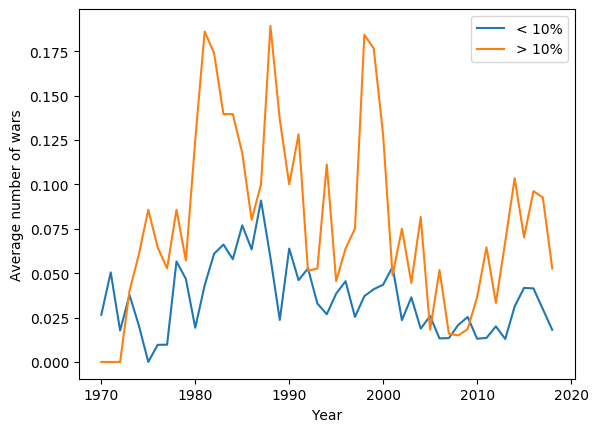

In [129]:
plt.rcdefaults()
plt.plot(dix)
#plt.plot(deux)
plt.plot(Trois)
plt.xlabel("Year")
plt.ylabel("Average number of wars")
plt.legend(["< 10%","> 10%"])#"between 10% and 20%"
#plt.savefig("Natural_Ressources_war.png")

# VAR

In [205]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

## define the data

In [406]:
data = df.groupby("Year").mean()[['Language','Account Balance','Corruption','Foreign_Investment','GDP','Inflation','Ethnicity','Religion','unemployment','Natural Ressources','Infant Mortality','conflict']]
dates = data.index.astype(int).astype(str)
from statsmodels.tsa.base.datetools import dates_from_str

dates = dates_from_str(dates)
data.index = pandas.DatetimeIndex(dates)
data = data.fillna(data.mean())

## split

In [407]:
nobs = 4
df_train, df_test = data[0:-nobs], data[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(55, 12)
(4, 12)


## differentiate

In [411]:
df_differenced = df_train.diff().dropna()

In [350]:
df_differenced = df_differenced.diff().dropna()

In [412]:
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Language" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8567
 No. Lags Chosen       = 1
 Critical value 1%     = -3.563
 Critical value 5%     = -2.919
 Critical value 10%    = -2.597
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Account Balance" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.6209
 No. Lags Chosen       = 0
 Critical value 1%     = -3.56
 Critical value 5%     = -2.918
 Critical value 10%    = -2.597
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Corruption" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significa

In [432]:
model = VAR(df_differenced)
for i in [1,2,3]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

/home/chekirou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


Lag Order = 1
AIC :  -40.47194577729115
BIC :  -34.672595994005654
FPE :  2.995457273030471e-18
HQIC:  -38.241795550504975 

Lag Order = 2
AIC :  -40.21294814408956
BIC :  -28.955772844581325
FPE :  9.686611375911872e-18
HQIC:  -35.897212819278536 

Lag Order = 3
AIC :  -48.6231159742302
BIC :  -31.804869289336068
FPE :  7.97391028634299e-20
HQIC:  -42.196366488386744 



In [414]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Jun, 2020
Time:                     01:47:50
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                   -31.8049
Nobs:                     51.0000    HQIC:                  -42.1964
Log likelihood:           815.499    FPE:                7.97391e-20
AIC:                     -48.6231    Det(Omega_mle):     1.14478e-22
--------------------------------------------------------------------
Results for equation Language
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.001895         0.002088           -0.908           0.364
L1.Language                  -0.227319         0.446964           -0.509           0.611
L1.Account Balance       

In [415]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_differenced.columns, out):
    print((col), ':', round(val, 2))

Language : 2.02
Account Balance : 1.57
Corruption : 1.49
Foreign_Investment : 2.22
GDP : 2.06
Inflation : 1.84
Ethnicity : 1.79
Religion : 2.25
unemployment : 1.81
Natural Ressources : 1.83
Infant Mortality : 1.86
conflict : 2.0


In [416]:
df_differenced

,Language,Account Balance,Corruption,Foreign_Investment,GDP,Inflation,Ethnicity,Religion,unemployment,Natural Ressources,Infant Mortality,conflict
1961-12-31,0.001719,0.984572,-0.043127,0.000000,-0.661699,-0.609481,0.001301,0.000006,-3.120675,0.000000,-1.455732,0.030606
1962-12-31,0.002498,0.143221,-0.094439,0.000000,1.486455,1.094831,0.000943,0.000721,-0.650000,0.000000,1.380353,0.000448
1963-12-31,-0.003217,-0.346556,0.022099,0.000000,0.003348,1.114918,-0.001520,0.000552,0.100000,0.000000,-2.006677,0.000000
1964-12-31,0.004192,-0.893891,-0.127732,0.000000,0.282530,0.633071,0.001335,-0.000943,-0.350000,0.000000,0.262786,0.025452
1965-12-31,-0.002718,-1.236454,0.016304,0.000000,-0.132267,6.473254,-0.002114,-0.002267,-0.300000,0.000000,-2.973172,0.008929
1966-12-31,-0.001762,1.117678,0.025808,0.000000,-1.132120,6.823614,-0.001510,0.000887,-0.300000,0.000000,-1.144797,0.000601
1967-12-31,0.003306,0.803832,0.262119,0.000000,-0.017811,-13.865571,-0.001458,-0.002641,0.000000,0.000000,-1.978428,0.033612
1968-12-31,-0.002664,-1.133107,-0.126775,0.000000,2.189322,0.806428,0.002388,0.003534,-0.150000,0.000000,-3.428427,-0.045970
1969-12-31,-0.001626,-1.004704,0.012197,0.000000,-0.107656,-2.467289,-0.000942,0.000070,2.904667,0.000000,-1.560065,0.030294
1970-12-31,0.002561,0.161638,0.059869,-1.727868,0.555036,0.727817,-0.000111,-0.000552,0.003884,-2.265100,-2.557093,-0.026340


## forcasting

In [423]:
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_test.diff().dropna().values[-lag_order:]
forecast_input

3


array([[ 2.76028504e-03,  2.36177040e-01,  4.90781410e-01,
        -2.23359014e+00,  1.51268178e-01,  8.80865806e-01,
        -7.31649191e-04,  7.48537694e-03, -2.13365245e-01,
        -5.42256620e-01, -9.78764514e-01,  1.23503740e-02],
       [-1.27359781e-03,  6.33444741e-01, -1.81293734e-01,
        -3.41389062e-01,  2.81081066e-01,  3.74457099e-01,
         5.78419720e-04, -4.13208796e-03, -2.24192417e-01,
         1.06674759e+00, -4.46653018e-01, -1.80844430e-02],
       [ 7.43624295e-04,  1.20203502e-01, -7.68702088e-02,
        -8.60531525e-01, -2.88373757e-01,  1.22384888e-01,
         5.77752319e-04, -1.99607019e-03, -7.47203334e-02,
         1.18126163e-02, -7.22399180e-01,  1.18567012e-02]])

In [425]:
nobs = 3
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_differenced.index[-nobs:], columns=df_differenced.columns + '_2d')
df_forecast

,Language_2d,Account Balance_2d,Corruption_2d,Foreign_Investment_2d,GDP_2d,Inflation_2d,Ethnicity_2d,Religion_2d,unemployment_2d,Natural Ressources_2d,Infant Mortality_2d,conflict_2d
2012-12-31,-0.003430,1.544798,-0.398243,1.990701,-2.422715,-37.213064,0.001869,-0.002915,0.158759,-0.512653,0.940975,0.019149
2013-12-31,0.004484,-0.468924,0.361653,-1.597691,2.143621,17.041296,0.001421,0.004807,-0.189963,0.432491,-2.006796,-0.036139
2014-12-31,-0.001734,-0.313926,-0.277247,-1.719477,0.311733,47.212380,-0.000038,-0.000334,-0.131836,2.556788,-1.561431,0.014654


In [426]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_2d'].cumsum()
    return df_fc


In [427]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)  

Text(0, 0.5, 'average number of conflicted countries')

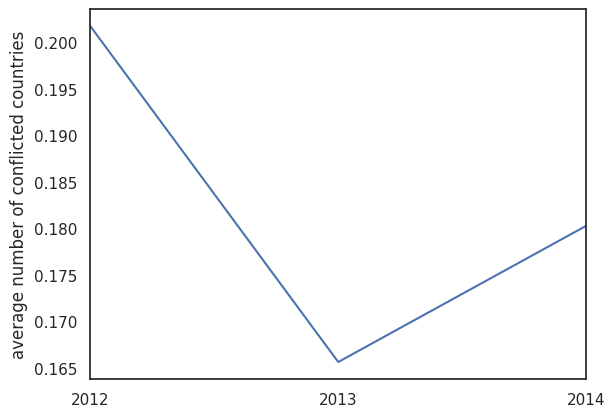

In [428]:
## plot
df_results["conflict_forecast"].plot()
plt.ylabel("average number of conflicted countries")

In [431]:
df["Country"].unique().shape

(215,)

In [222]:
# some example data
import numpy as np
import pandas

import statsmodels.api as sm

from statsmodels.tsa.api import VAR
data = df.groupby("Year").mean()[['Language','Debt','Account Balance','Corruption','Foreign_Investment','GDP','Inflation','Ethnicity','Religion','unemployment','Natural Ressources','Infant Mortality','incompatibility','intensity_level','minor conflict','war','conflict','internationalized internal','internal','interstate','extrasymetric','emergence','War emergence']]


# prepare the dates index
#dates = mdata[['year', 'quarter']]

dates = data.index.astype(int).astype(str)

from statsmodels.tsa.base.datetools import dates_from_str

dates = dates_from_str(dates)

#mdata = mdata[['realgdp','realcons','realinv']]

data.index = pandas.DatetimeIndex(dates)


#data = np.log(data).diff().dropna()

# make a VAR model
model = VAR(data)

/home/chekirou/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)
